In [1]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from itertools import zip_longest
from typing import Set, List
import requests
import logging
import csv


In [2]:
REDDIT_API_URL = 'https://api.pushshift.io/reddit'
REDDIT_SEARCH_COMMENT_ENDPOINT = '/comment/search'
REDDIT_SEARCH_COMMENT_URL = f'{REDDIT_API_URL}{REDDIT_SEARCH_COMMENT_ENDPOINT}'
DESIRED_AUTHORS_AMOUNT = 1000
AUTHORS_CSV_FILE_NAME = 'subreddit_authors.csv'
SUBREDDITS_INTERSECTIONS_CSV_NAME = 'subreddits_intersections.csv'
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:
subreddits_names = ['r/classicalmusic', "r/opera", "r/ambientmusic", "r/chillout", "r/deephouse", "r/DnB", "r/dubstep",
                    "r/EDM", "r/electronicdancemusic", "r/rock", "r/indieheads", "r/electronicmusic", "r/blues", "r/folk",
                    "r/Metal", "r/punk", "r/hiphopheads", "r/hiphop101", "r/rap", "r/Jazz", "r/reggae"]


In [4]:
def list_subreddit_authors(subreddit_name: str, limit: int = DESIRED_AUTHORS_AMOUNT) -> Set[str]:
    logger.info(
        f'Fetching <{limit}> subreddit_authors from <{subreddit_name}> subreddit')
    authors_set = set()
    params = {
        'subreddit': subreddit_name,
        'size': 1000,
        'fields': 'author'
    }
    index_base = 0
    index = 0
    while len(authors_set) < limit:
        logger.debug(
            f'Fetching the bulk that starts with the <{index_base+index}> author')
        index_base += index
        response = requests.get(REDDIT_SEARCH_COMMENT_URL, params=params)
        data = response.json()
        if not data['data']:
            break
        for index, comment in enumerate(data.get('data')):
            authors_set.add(comment.get('author'))
        params['before'] = data.get('data')[-1].get('created_utc')
        logger.debug('Still working...')
    logger.info(
        f'Done fetching <{limit}> subreddit_authors from <{subreddit_name}> subreddit')
    return authors_set


In [5]:
authors_by_subreddit: List[Set[str]] = []
for subreddit in subreddits_names:
    subreddit_authors = list_subreddit_authors(subreddit)
    authors_by_subreddit.append(subreddit_authors)


INFO:__main__:Fetching <1000> subreddit_authors from <r/classicalmusic> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/classicalmusic> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from <r/opera> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/opera> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from <r/ambientmusic> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/ambientmusic> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from <r/chillout> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/chillout> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from <r/deephouse> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/deephouse> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from <r/DnB> subreddit
INFO:__main__:Done fetching <1000> subreddit_authors from <r/DnB> subreddit
INFO:__main__:Fetching <1000> subreddit_authors from

In [6]:
def write_subreddits_authors_to_csv(values: Set[str], labels: List[str]) -> None:
    logger.info(
        f'Writing authors names of comments in <{len(values)}> subreddits to file: <{AUTHORS_CSV_FILE_NAME}>')
    with open(AUTHORS_CSV_FILE_NAME, mode='w') as file:
        writer = csv.writer(file)
        writer.writerow(labels)
        for row in zip_longest(*values, fillvalue=''):
            writer.writerow(row)
    logger.info('Done writing to CSV file')


In [7]:
def plot_and_save_venn_diagram(authors_by_subreddit: list, labels: List[str]):
    venn3(authors_by_subreddit[:3], set_labels=(labels))
    logger.info(
        'Plotting 1 exapmple venn diagram to demonstrated example intersection between subreddits')
    plt.savefig('venn_diagram.png')


In [8]:
def write_authors_intersections_to_csv(authors_by_subreddit: list, labels: List[str]):
    intersections = []
    intersections_labels = []

    logger.info('Calgulating intersections between subreddits...')
    for i in range(len(authors_by_subreddit)):
        for j in range(i+1, len(authors_by_subreddit)):
            intersections.append(
                authors_by_subreddit[i].intersection(authors_by_subreddit[j]))
            intersections_labels.append(f'{labels[i]} & {labels[j]}')
            logger.debug(
                f"{labels[i]} & {labels[j]} {authors_by_subreddit[i].intersection(authors_by_subreddit[j])}")

    with open(SUBREDDITS_INTERSECTIONS_CSV_NAME, mode='w') as file:
        writer = csv.writer(file)
        writer.writerow(intersections_labels)
        for row in zip_longest(*intersections, fillvalue=''):
            writer.writerow(row)
    logger.info(
        f'All intersections between subreddits were persisted as CSV file called <{SUBREDDITS_INTERSECTIONS_CSV_NAME}>')


write_authors_intersections_to_csv(authors_by_subreddit, subreddits_names)


INFO:__main__:Calgulating intersections between subreddits...
INFO:__main__:All intersections between subreddits were persisted as CSV file called <subreddits_intersections.csv>


INFO:__main__:Writing authors names of comments in <21> subreddits to file: <subreddit_authors.csv>
INFO:__main__:Done writing to CSV file
INFO:__main__:Plotting 1 exapmple venn diagram to demonstrated example intersection between subreddits


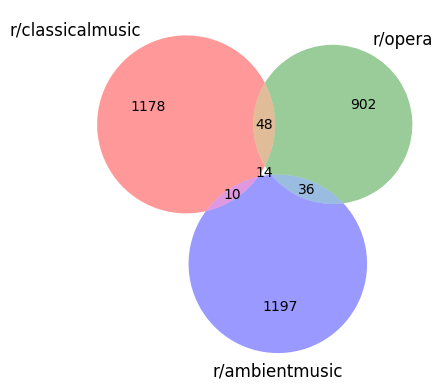

In [9]:
write_subreddits_authors_to_csv(authors_by_subreddit, subreddits_names)
plot_and_save_venn_diagram(authors_by_subreddit, subreddits_names)
